# Timing

In [2]:
using NBInclude;
using Plots;
using Statistics;
@nbinclude("GPUFilterBanks.ipynb");
@nbinclude("AudioTools.ipynb");

In [3]:
x = load("three_minute_warning.wav");
fs = round(Int,x.samplerate);
x = Float32.(x[:]);

In [4]:
N_list = 2 .^ ([15,18,22,26]);

In [5]:
num_octaves = 10;

filters = [
    WT.makeqmfpair(wavelet(WT.haar)),
    WT.makereverseqmfpair(wavelet(WT.haar))
];
LA = tensor(Float32.(filters[1][1]));
HA = tensor(Float32.(filters[1][2]));
LS = tensor(Float32.(filters[2][1]));
HS = tensor(Float32.(filters[2][2]));

In [6]:
n_trials = 5;
x_i = nothing
y = nothing
elapsed_time = zeros(length(N_list),2,n_trials);
for (N,i_N) ∈ zip(N_list,1:length(N_list)), trial ∈ 1:n_trials
    x_i = [tensor(x[1:N])]
    elapsed_time[i_N,1,trial] = Base.@elapsed y = analysis_filterbank(x_i,LA,HA)
    elapsed_time[i_N,2,trial] = Base.@elapsed synthesis_filterbank(y,LS,HS)
    y = nothing
end
elapsed_time = median(elapsed_time,dims=3)[:,:]

4×2 Matrix{Float64}:
 0.00816263  0.0123718
 0.0106195   0.0186567
 0.0230988   0.0673673
 0.608797    1.77462

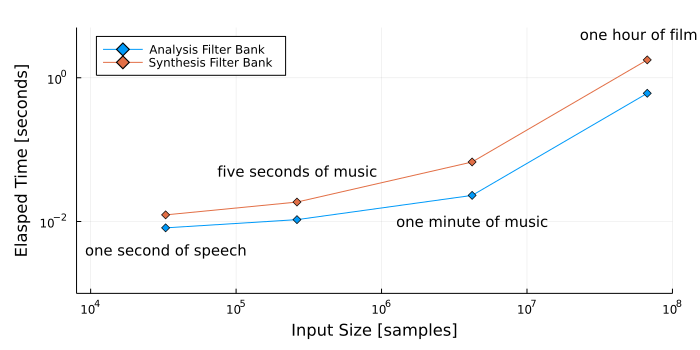

In [7]:
h = plot(N_list,elapsed_time,
    seriestype = :line,
    marker = :d,
    xaxis=:log, yaxis=:log,
    labels=["Analysis Filter Bank" "Synthesis Filter Bank"],
    size=(700,350),
    xlim=(8e3,1e8),
    ylim=(1e-3,5),
    legend=:topleft,
    ylab="Elasped Time [seconds]",xlab="Input Size [samples]",
    margin=5Plots.mm,
)
annotate!(h, 
    2^15 , 4e-3 ,
    text("one second of speech",:black, :center, 10))
annotate!(h, 
    2^18 , 5e-2 ,
    text("five seconds of music",:black, :center, 10))
annotate!(h, 
    2^22 , 1e-2 ,
    text("one minute of music",:black, :center, 10))
annotate!(h, 
    2^(25.8) , 4 ,
    text("one hour of film",:black, :center, 10))

In [6]:
;cat seq_time.py

import librosa
import numpy as np
import time
y,sr = librosa.load("three_minute_warning.wav")
for N in [2**15,2**18,2**22,2**26]:
    t1 = time.time()
    x_i = y[0:N]
    S = librosa.feature.melspectrogram(
        y=x_i,
        sr=sr,
        n_fft=2^20,
        hop_length=32,
        n_mels=512,
    )
    t2 = time.time()
    print(t2-t1,"\n")
    
    t1 = time.time()
    y_rec = librosa.feature.inverse.mel_to_audio(
        M=S,
        sr=sr,
        n_fft=2^20,
        hop_length=32,
    )
    t2 = time.time()
    print(t2-t1,"\n")

In [7]:
;taskset --cpu-list 0 python3 seq_time.py

0.017119169235229492 

0.09121012687683105 

0.016405582427978516 

0.6389076709747314 

0.21744465827941895 

10.451849699020386 

1.606813669204712 

90.8090467453003 



/usr/local/lib/python3.9/dist-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [11]:
cpu_time = reshape([
    0.017119169235229492 
    0.09121012687683105 
    0.016405582427978516 
    0.6389076709747314 
    0.21744465827941895 
    10.451849699020386 
    1.606813669204712 
    90.8090467453003 
],(2,4))'

4×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0171192   0.0912101
 0.0164056   0.638908
 0.217445   10.4518
 1.60681    90.809

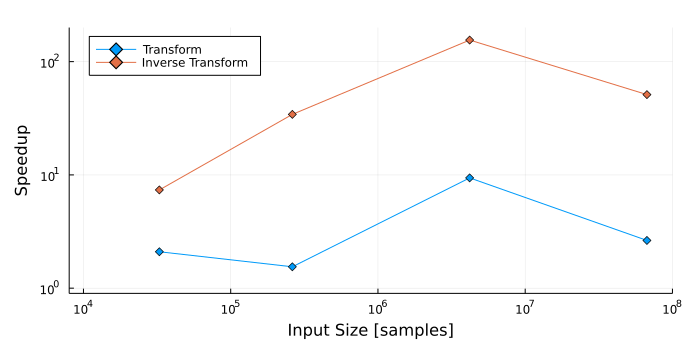

In [28]:
h = plot(N_list,cpu_time./elapsed_time,
    seriestype = :line,
    marker = :d,
    xaxis=:log, yaxis=:log,
    labels=["Transform" "Inverse Transform"],
    size=(700,350),
    ylim=(0.9,200),
    xlim=(8e3,1e8),
    legend=:topleft,
    ylab="Speedup",xlab="Input Size [samples]",
    margin=5Plots.mm,
)